# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import sys

sys.path.append("../../src/")

from utils import read_bb_data 

# Parsing files

In [2]:
result_files = [f for f in os.listdir("../../../energy_dataset/") if f.endswith("results")]
data_df = pd.DataFrame()

for file in result_files:
    file_df = read_bb_data(f"../../../energy_dataset/{file}/breaker_code.txt", f"../../../energy_dataset/{file}/breaker_final_energy.txt")
    file_df = file_df.drop(columns=["bb_name"])
    data_df = pd.concat([data_df, file_df], ignore_index=True)

Read file: 5500it [00:00, 1571649.54it/s]
Read file: 1007it [00:00, 672343.86it/s]
Read file: 23757it [00:00, 389438.53it/s]
Read file: 3281it [00:00, 729821.35it/s]
Read file: 65377it [00:00, 1485803.68it/s]
Read file: 10955it [00:00, 842567.95it/s]
Read file: 6018it [00:00, 1337288.55it/s]
Read file: 988it [00:00, 657773.39it/s]
Read file: 58765it [00:00, 1416053.51it/s]
Read file: 10347it [00:00, 899692.42it/s]
Read file: 7827it [00:00, 1563277.02it/s]
Read file: 1281it [00:00, 639707.52it/s]
Read file: 307469it [00:00, 1653066.65it/s]
Read file: 55158it [00:00, 904242.03it/s]
Read file: 300342it [00:00, 1264570.22it/s]
Read file: 49541it [00:00, 917845.01it/s]
Read file: 117151it [00:00, 1521339.85it/s]
Read file: 19125it [00:00, 932994.45it/s]
Read file: 32428it [00:00, 1441196.19it/s]
Read file: 3856it [00:00, 969560.35it/s]
Read file: 252048it [00:00, 1139126.05it/s]
Read file: 41397it [00:00, 930197.54it/s]
Read file: 226630it [00:00, 1520946.59it/s]
Read file: 39698it [00:00, 

In [3]:
print(f"Number of basic blocks: {len(data_df)}")

Number of basic blocks: 565679


In [4]:
data_df.head(5)

,bb,energy
0,"[movl $0x0, -0x2c(%rbp)]",0.842119
1,"[callq 0xfffffffffffffeff, pushq %rbp, mov %...",0.358601
2,"[popq %rbp, retq]",0.165508
3,"[movl $0x0, -0x1c(%rbp)]",0.842119
4,"[cmpl $0x64, -0x1c(%rbp), jnl 0x2c]",1.263179


# Analysis

Distribution based on number of instructions

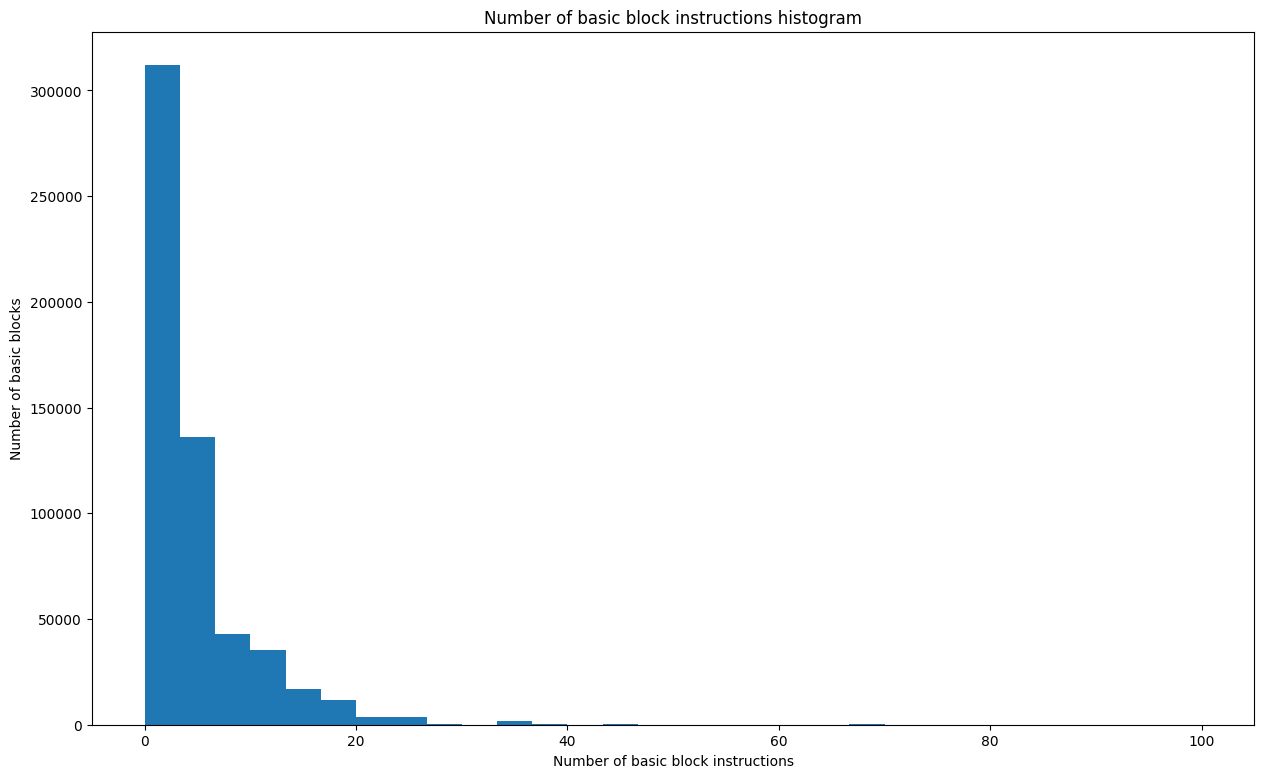

In [5]:
bb_instruction_num = data_df.bb.apply(lambda x: len(x)).values

plt.figure(figsize=(15,9))
plt.title("Number of basic block instructions histogram")
plt.xlabel("Number of basic block instructions")
plt.ylabel("Number of basic blocks")
plt.hist(bb_instruction_num, bins=30, range=(0,100))
plt.show()

In [6]:
MAX_INSTRUCTIONS = 20

data_df = data_df[data_df.bb.apply(lambda x: len(x)) <= MAX_INSTRUCTIONS]
data_df = data_df.reset_index(drop=True)
print(f"Number of data with bb up to {MAX_INSTRUCTIONS} instructions: {len(data_df)}")

Number of data with bb up to 20 instructions: 555854


Energy distribution

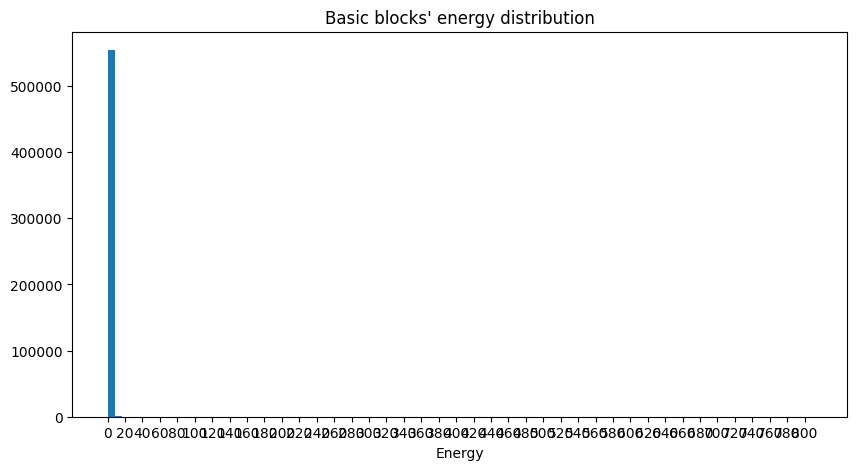

In [7]:
x_ticks = np.arange(data_df.energy.min(), data_df.energy.max(), 20)

plt.figure(figsize=(10, 5))
plt.hist(data_df.energy, bins=100)
plt.title("Basic blocks' energy distribution")
plt.xlabel("Energy")
plt.xticks(x_ticks)
plt.show()

In [8]:
outlier_bb = data_df.loc[data_df.energy.idxmax()]
outlier_bb.bb

['mov %r12d, %esi',
 'mov $0x2, %edi',
 'callq  0x250ee',
 'nop %edi, %edx',
 'pushq  %r12',
 'pushq  %rbp',
 'pushq  %rbx',
 'mov %esi, %ebx',
 'test %edi, %edi',
 'jnz 0x74']

We remove the outliers and data with 0 energy

In [9]:
perc = len(data_df[data_df.energy < 10]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 10: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 5]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 5: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 2]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 2: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 1]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 1: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 0.5]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 0.5: {round(perc, 2)}%")

perc = len(data_df[data_df.energy == 0.0]) * 100/ len(data_df)
print(f"Percentage of basic blocks with 0 energy: {round(perc, 2)}%")

Percentage of basic blocks with energy lower than 10: 99.84%
Percentage of basic blocks with energy lower than 5: 99.53%
Percentage of basic blocks with energy lower than 2: 97.41%
Percentage of basic blocks with energy lower than 1: 92.17%
Percentage of basic blocks with energy lower than 0.5: 81.36%
Percentage of basic blocks with 0 energy: 0.51%


In [10]:
data_df = data_df[data_df.energy > 0.0]
data_df = data_df[data_df.energy < 10.0]

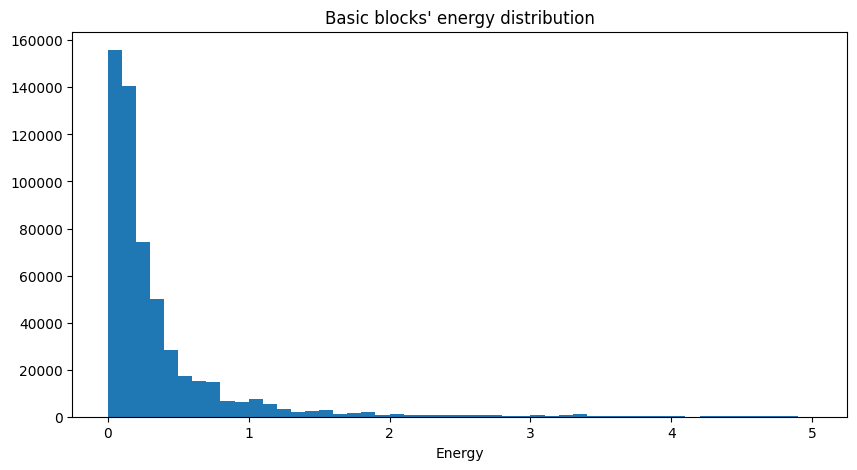

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(data_df.energy, range=(0, 5), bins=50)
plt.title("Basic blocks' energy distribution")
plt.xlabel("Energy")
plt.show()

In [12]:
median = np.median(data_df.energy.values)
std = np.std(data_df.energy.values)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.18174110027428655, Labels' std: 0.6428597933036999


In [13]:
grouped_df = data_df.groupby(data_df["bb"].map(tuple))["energy"].apply(list).reset_index()
grouped_df.head(5)

,bb,energy
0,"(add $0x1, %esi, cmp $0x270f, %esi, jnle 0xf)",[0.016677364772608463]
1,"(add $0x1, %esi, movl %esi, (%rax), cmpl %es...","[1.052697559160445, 1.5276753937910126, 0.5167..."
2,"(add $0x1, %r10, mov %rbx, %rdx, movsxb 0x1(%...","[0.27174238549467133, 0.27174238549467133, 0.2..."
3,"(add $0x1, %r15, movq 0x28(%r12), %rax, movzx...","[1.1483980499316333, 1.1483980499316333, 1.148..."
4,"(add $0x1, %r9d, cmpq $0x0, -0x500(%rbp), jz ...","[0.17353786933730966, 0.17353786933730966, 0.1..."


In [14]:
multiple_energies_df = grouped_df[grouped_df.energy.map(len) > 1]
perc = len(multiple_energies_df) * 100 / len(grouped_df)
print(f"Number of basic blocks that appear multiple times: {round(perc, 2)}%")

Number of basic blocks that appear multiple times: 65.1%


# Energy distribution per program

Read file: 5500it [00:00, 1388675.17it/s]
Read file: 1007it [00:00, 668830.42it/s]


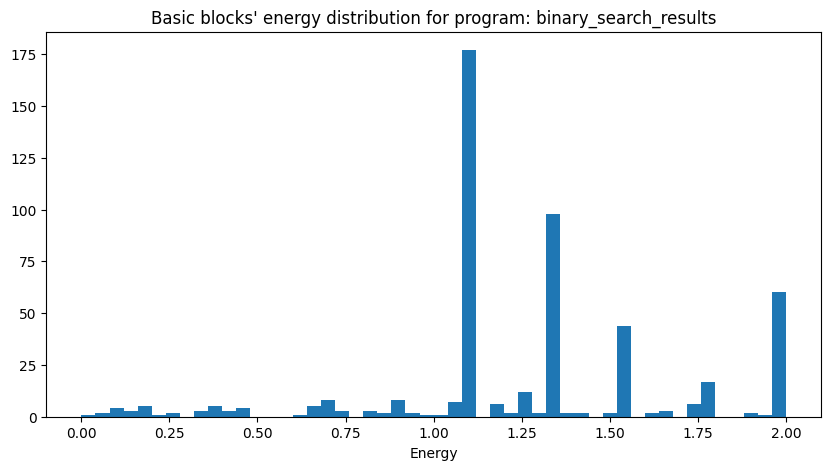

Read file: 23757it [00:00, 1284602.93it/s]
Read file: 3281it [00:00, 819430.24it/s]


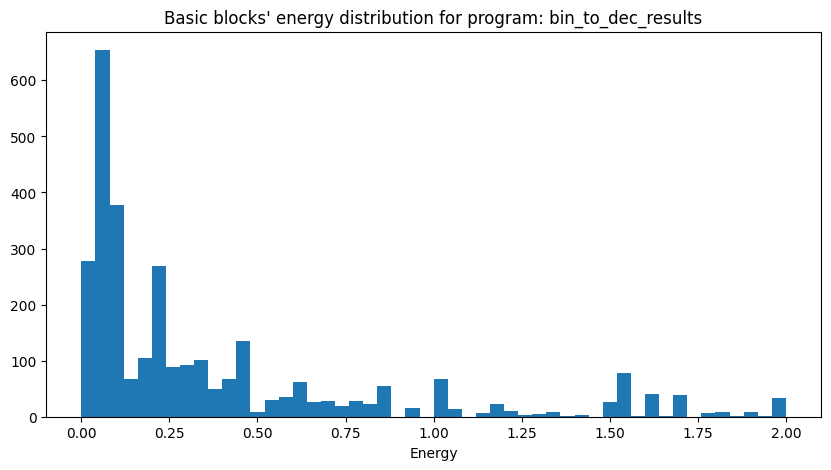

Read file: 65377it [00:00, 1502929.62it/s]
Read file: 10955it [00:00, 912910.28it/s]


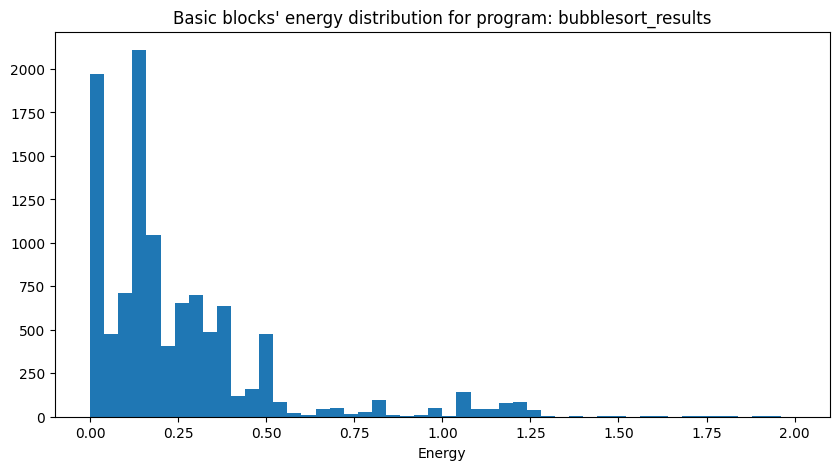

Read file: 6018it [00:00, 1335307.70it/s]
Read file: 988it [00:00, 656835.05it/s]


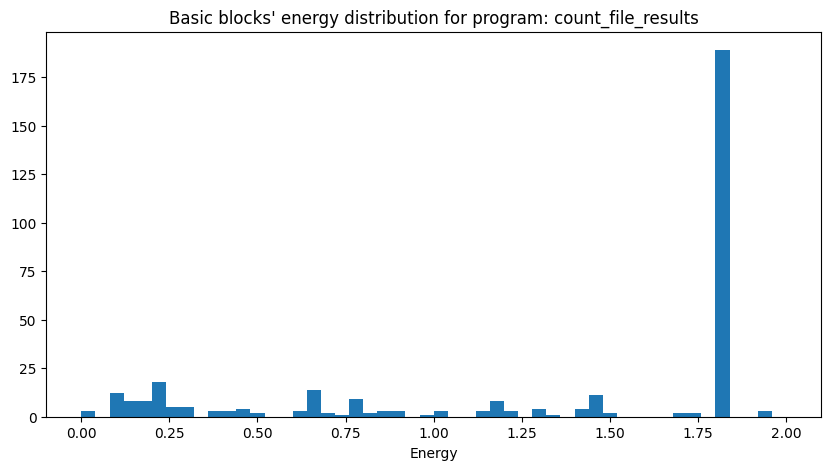

Read file: 58765it [00:00, 1469117.64it/s]
Read file: 10347it [00:00, 900121.61it/s]


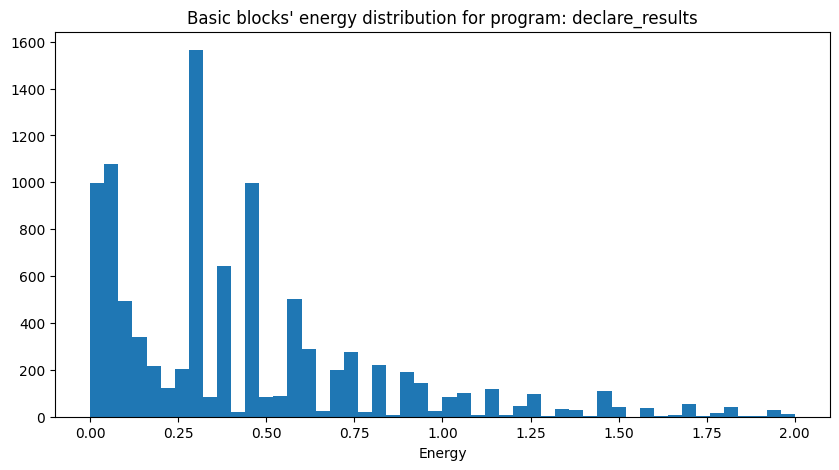

Read file: 7827it [00:00, 1424243.71it/s]
Read file: 1281it [00:00, 855285.49it/s]


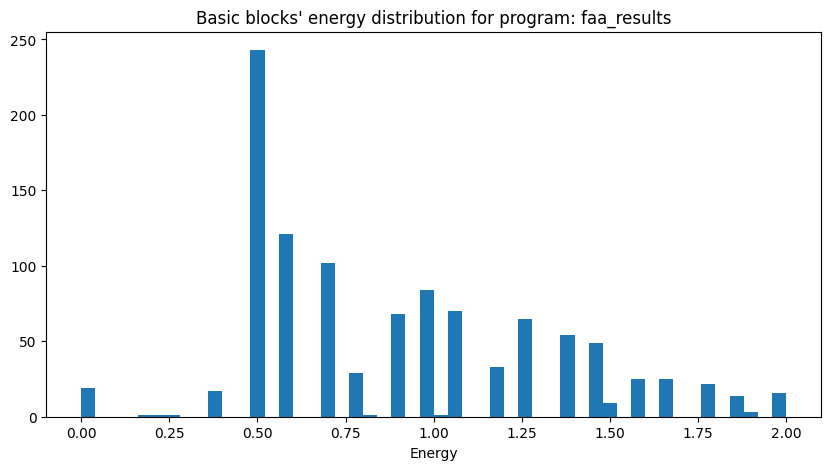

Read file: 307469it [00:00, 1609520.27it/s]
Read file: 55158it [00:00, 943574.70it/s]


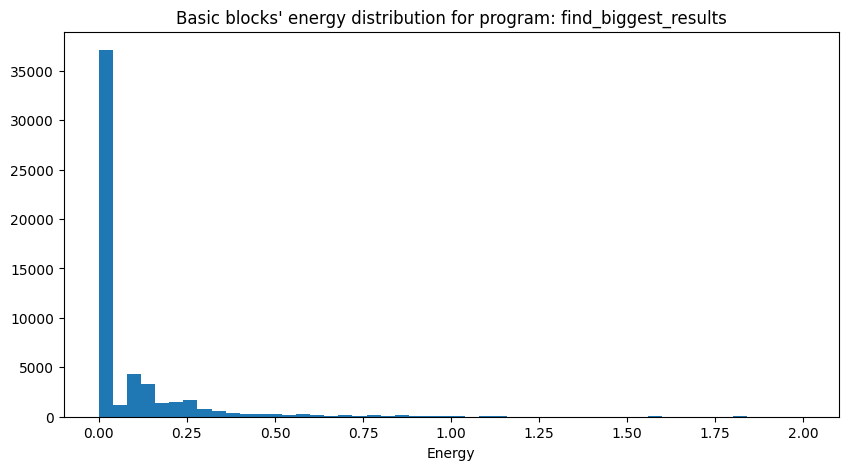

Read file: 300342it [00:00, 803049.22it/s] 
Read file: 49541it [00:00, 839759.19it/s]


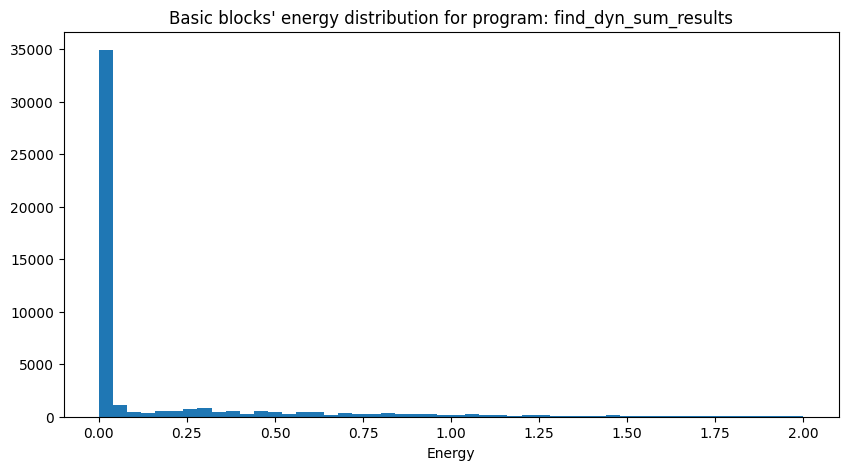

Read file: 117151it [00:00, 1541311.14it/s]
Read file: 19125it [00:00, 932831.71it/s]


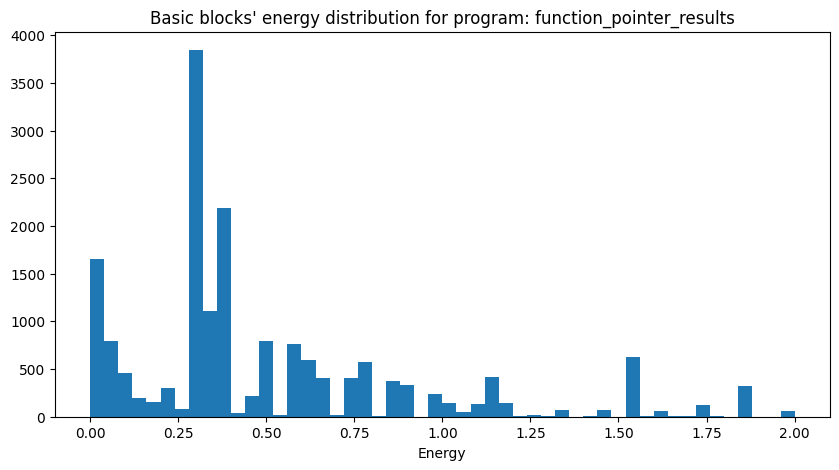

Read file: 32428it [00:00, 1508237.86it/s]
Read file: 3856it [00:00, 855409.97it/s]


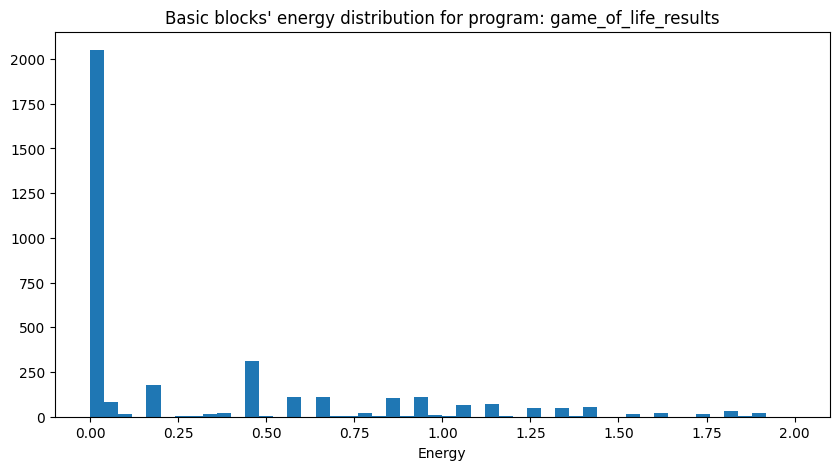

Read file: 252048it [00:00, 1594937.34it/s]
Read file: 41397it [00:00, 962785.37it/s]


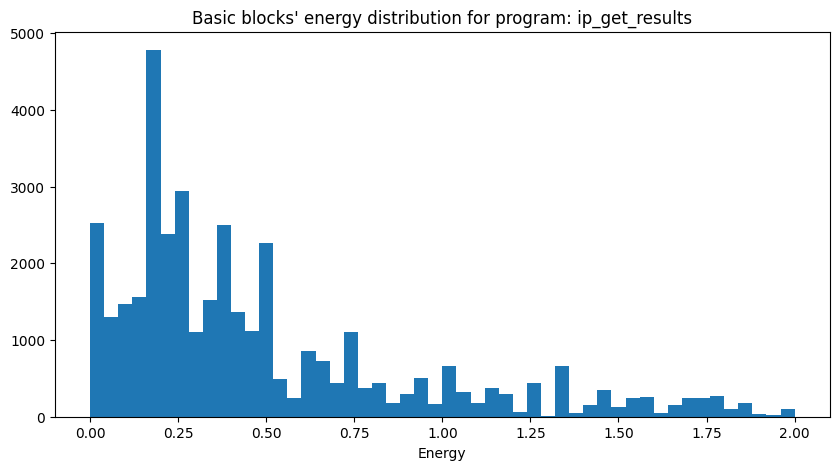

Read file: 226630it [00:00, 1660294.48it/s]
Read file: 39698it [00:00, 956592.69it/s]


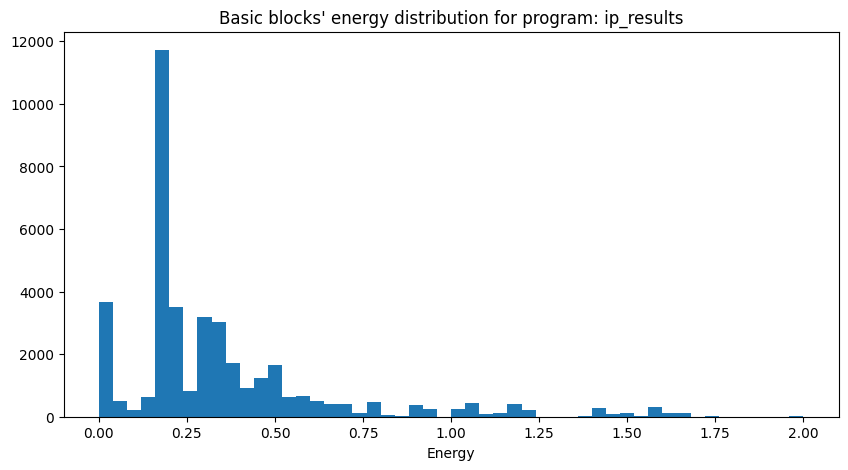

Read file: 45306it [00:00, 1486956.85it/s]
Read file: 6559it [00:00, 820203.33it/s]


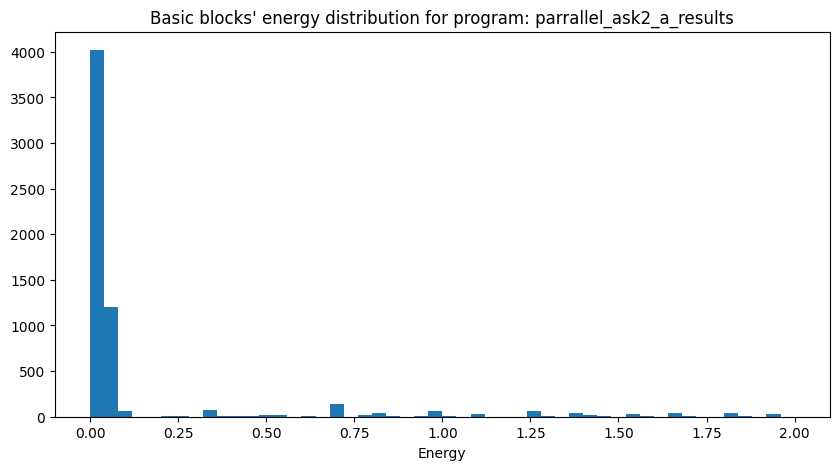

Read file: 45330it [00:00, 1536286.95it/s]
Read file: 6566it [00:00, 937588.94it/s]


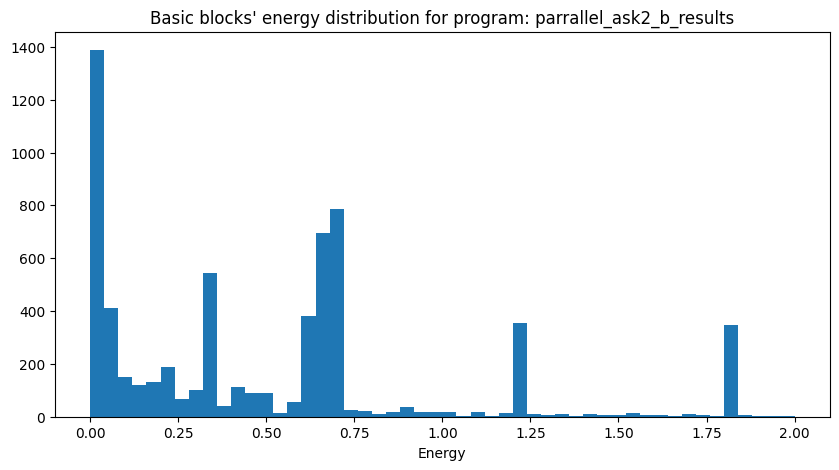

Read file: 87907it [00:00, 1555877.26it/s]
Read file: 14909it [00:00, 903236.63it/s]


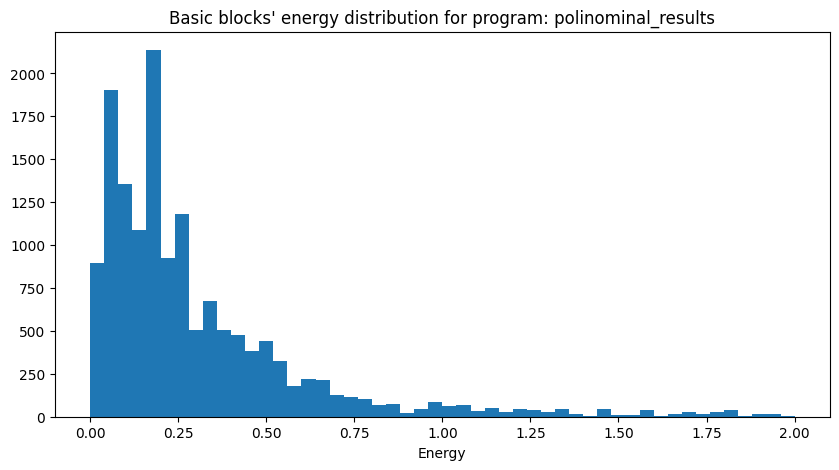

Read file: 96861it [00:00, 1445642.16it/s]
Read file: 15598it [00:00, 917274.28it/s]


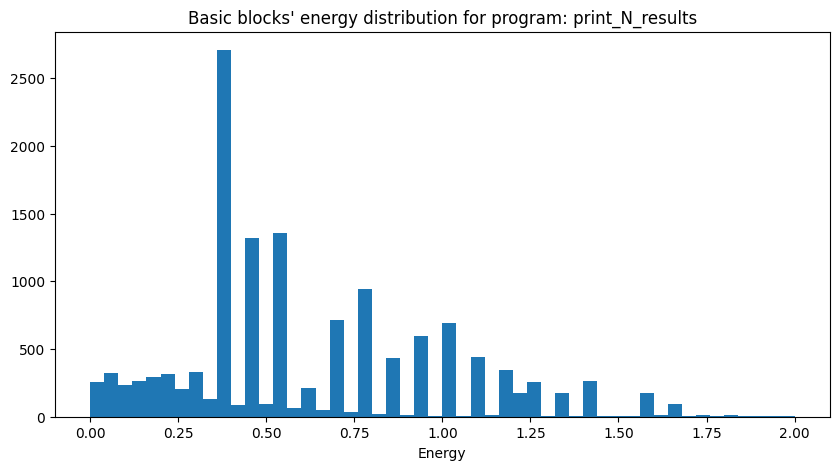

Read file: 112856it [00:00, 444304.62it/s]
Read file: 17381it [00:00, 914373.84it/s]


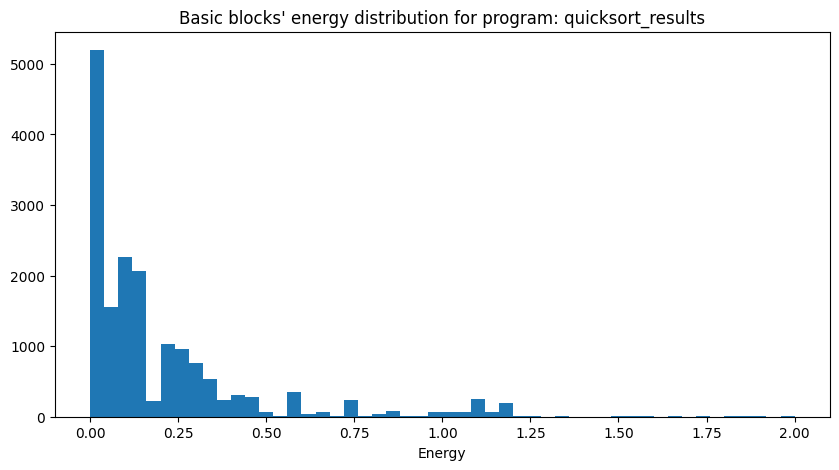

Read file: 87125it [00:00, 1476449.91it/s]
Read file: 13874it [00:00, 895478.48it/s]


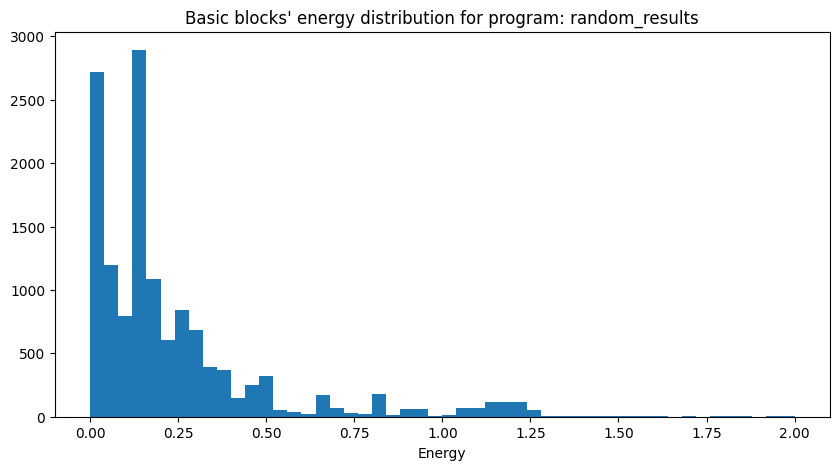

Read file: 37223it [00:00, 1404326.35it/s]
Read file: 6354it [00:00, 845648.35it/s]


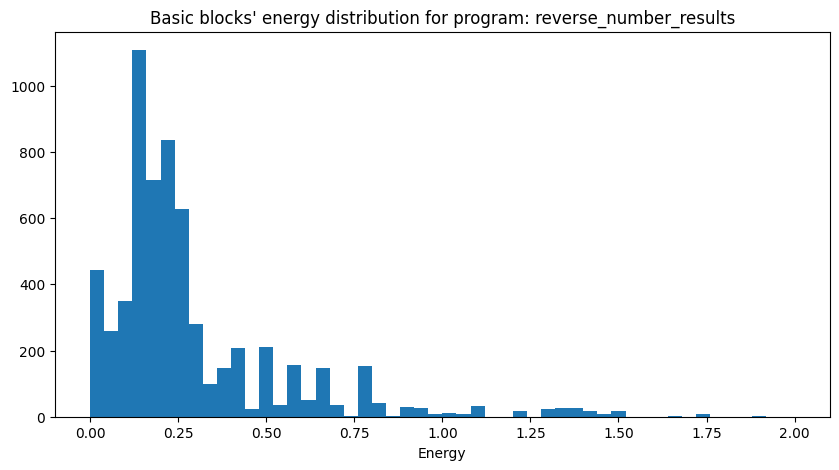

Read file: 43378it [00:00, 1421943.53it/s]
Read file: 7697it [00:00, 810228.58it/s]


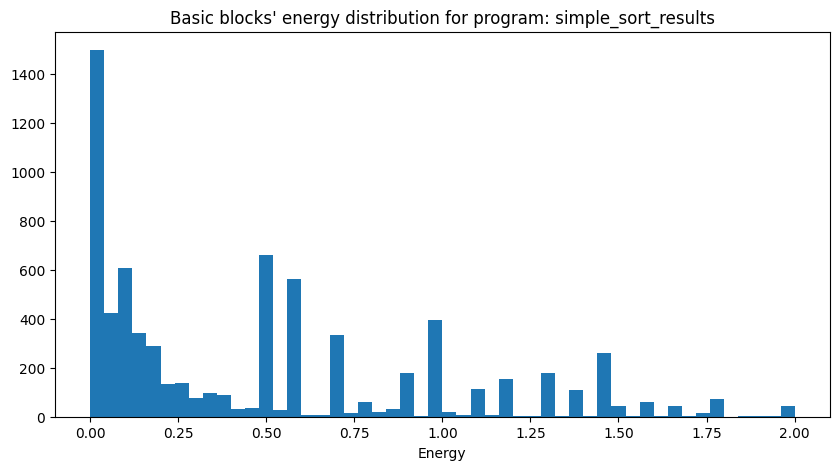

Read file: 15564it [00:00, 1414030.83it/s]
Read file: 2626it [00:00, 875257.65it/s]


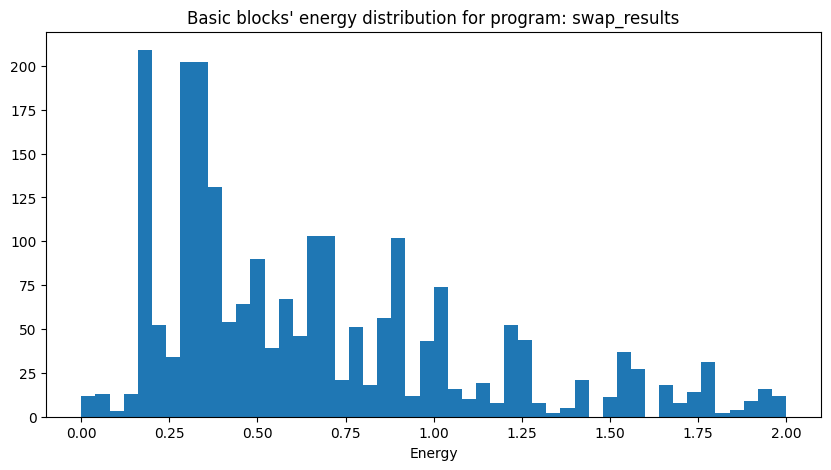

Read file: 142594it [00:00, 1447482.95it/s]
Read file: 23754it [00:00, 931518.54it/s]


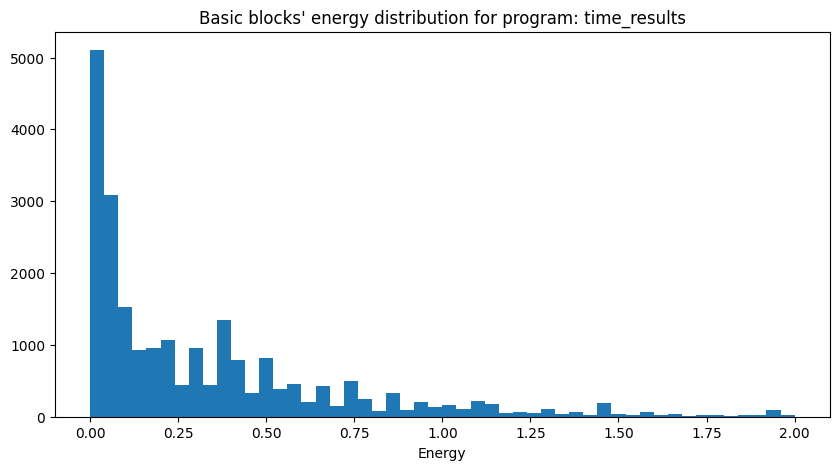

Read file: 1267388it [00:00, 1307931.24it/s]
Read file: 208473it [00:00, 916530.20it/s]


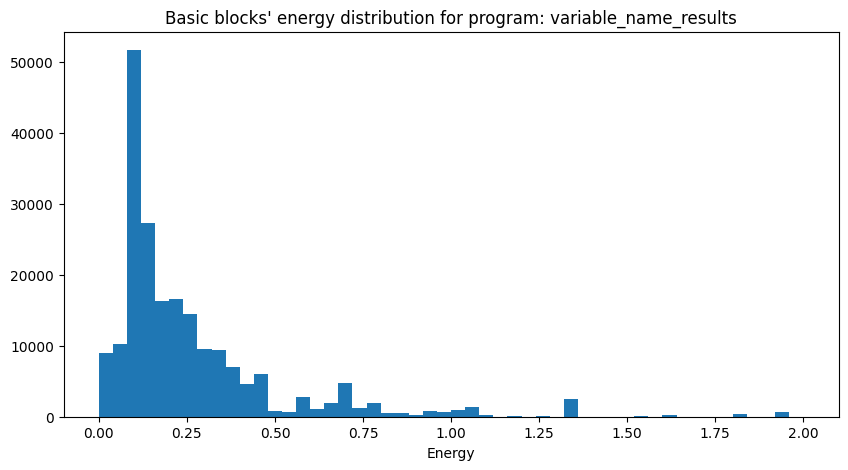

Read file: 36417it [00:00, 1486443.57it/s]
Read file: 5254it [00:00, 808366.28it/s]


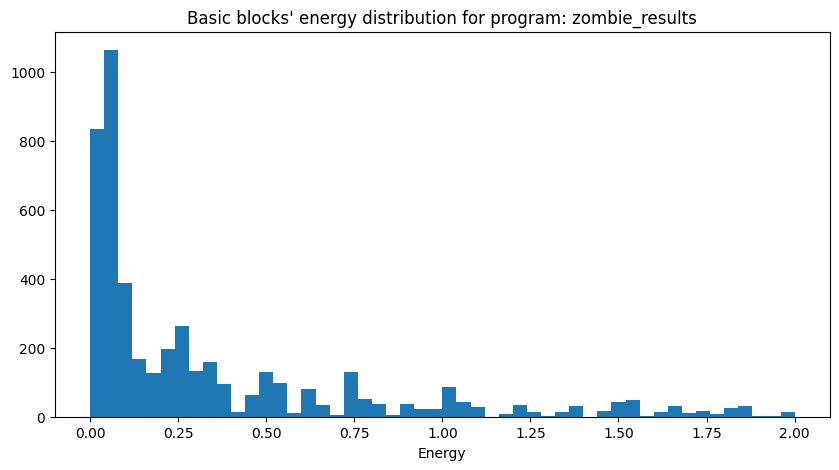

In [15]:
result_files = [f for f in os.listdir("../../../energy_dataset/") if f.endswith("results")]

for file in result_files:
    file_df = read_bb_data(f"../../../energy_dataset/{file}/breaker_code.txt", f"../../../energy_dataset/{file}/breaker_final_energy.txt")
    plt.figure(figsize=(10, 5))
    plt.hist(file_df.energy, range=(0, 2), bins=50)
    plt.title(f"Basic blocks' energy distribution for program: {file}")
    plt.xlabel("Energy")
    plt.show()